# Aprendizaje Automático 2
Tecnicatura Universitaria en Inteligencia Artificial

Materia: IA5.1

**Trabajo Práctico 1: Redes Densas y Convolucionales**


**Docentes:**
- Matias Moreyra
- Bruno Cocitto
- Facundo Moreyra



**Integrantes:**

| Apellido y Nombre | Legajo   |
| ----------------- | -------- |
| Aguirre, Fabián   | A-4516/1 |
| Fontela, Facundo  | F-3724/9 |
| Wagner, Juan      | W-0557/6 |

Año: 2024

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import keras
from pathlib import Path

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import recall_score
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling, Add
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from PIL import Image

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [ ]:
import os

REPO_NAME = "tp-aa2"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/facunob/{REPO_NAME}.git
  os.chdir(REPO_NAME)

Cloning into 'tp-aa2'...
remote: Enumerating objects: 24314, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 24314 (delta 0), reused 5 (delta 0), pack-reused 24309
Receiving objects: 100% (24314/24314), 343.53 MiB | 13.58 MiB/s, done.
Updating files: 100% (24337/24337), done.


# Ejercicio 1

### Descripción:
En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.
### Dataset:
El dataset proporcionado incluye las siguientes variables para cada estudiante:
- Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
- Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
- Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
- Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
- Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.

Además, el dataset incluye la variable objetivo:
- Performance Index: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.
### Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes. Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de regresión.


##Resolución

In [ ]:
df1 = pd.read_csv("datasets/ej1/Student_Performance.csv", sep=',',engine='python')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


- El dataset se cargó y se realizó un hot encoding de la variable categórica 'Extracurricular Activities'.
- Se examinaron las relaciones lineales entre las variables, observando una correlación significativa (0.92) entre "Previous Scores" y "Performance Index", lo que sugiere una relación casi lineal entre ambos.
- Los datos se dividieron en conjuntos de entrenamiento y prueba (80/20) y se separó la variable objetivo ('Performance Index').

In [ ]:
# Se hace hot encoding de la variable categorica 'Extracurricular Activities'.

df1 = pd.get_dummies(df1)
df1 = df1.drop('Extracurricular Activities_No', axis=1)
df1.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities_Yes
0,7,99,9,1,91.0,True
1,4,82,4,2,65.0,False
2,8,51,7,2,45.0,True
3,5,52,5,2,36.0,True
4,7,75,8,5,66.0,False


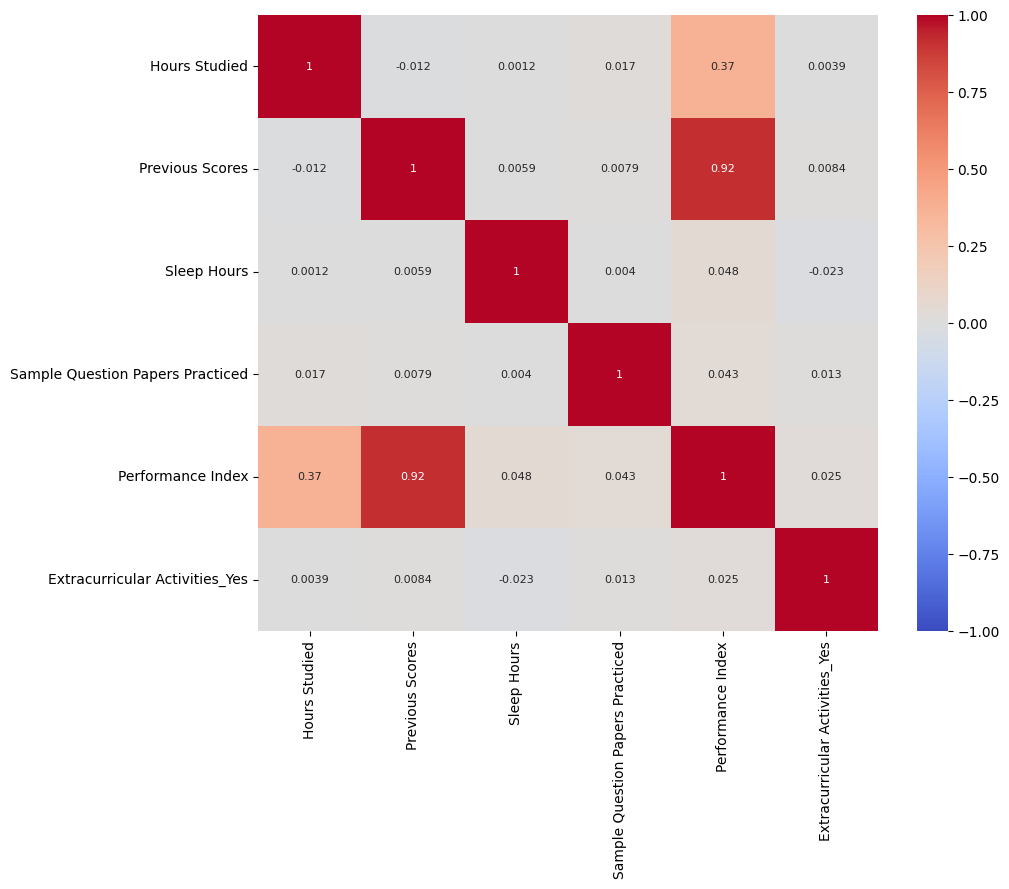

In [ ]:
# En el siguiente grafico observamos las relaciones lineales de los campos del dataset.
# Cabe destacar la relacion existente entre "Previous Scores" y "Performance Index" de 0.92.
# Esto indica que hay una relacion casi lineal entre ambos campos,
# por lo que una simple regresion ya permitiria obtener resultados "muy buenos". R2 ~ 0.92

df_corr1 = df1.corr()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    df_corr1,
    vmin=-1, vmax=1, center=0,
    cmap="coolwarm",
    annot = True,
    mask = np.triu(np.ones_like(df_corr1, dtype=bool)),
    annot_kws={"size": 8},
)
ax.set_title("Diagrama de Correlacion de Person")
plt.show()

In [ ]:
# Split de los datos en train/test y variable objetivo.

X_train1, X_test1, y_train1, y_test1 = train_test_split(df1.drop('Performance Index', axis=1),
                                              df1['Performance Index'].values.reshape(-1,1),
                                              test_size=0.2,
                                              random_state=12,
                                             )

In [ ]:
# Metodo que devuelve las metricas segun un y_test e y_prediccion
def metricas(y_test, y_pred):
  R2 = metrics.r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse_ols = mean_squared_error(y_test, y_pred, squared = False)
  mae = metrics.mean_absolute_error(y_test, y_pred)
  mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

  print(f"R2: {round(R2,2)}")
  print(f"MSE: {round(mse)}")
  print(f"RMSE: {round(rmse_ols)}")
  print(f"MAE: {round(mae)}")
  print(f"MAPE: {round(mape,2)}")

- Las características se estandarizaron para garantizar una escala común.
- Se diseñó una red neuronal secuencial con 5 capas: tres capas ocultas con activación ReLU y una capa de salida lineal.
- Se utilizó regularización L2 en la primera capa para evitar el sobreajuste.
- La función de pérdida seleccionada fue la 'mean_squared_error' y se utilizó el optimizador Adam.
- El modelo se entrenó durante 200 épocas con un tamaño de lote de 400, utilizando el 20% de los datos como conjunto de validación.

Epoch 1/200
16/16 [==============================] - 3s 51ms/step - loss: 3386.4797 - mse: 3386.4099 - val_loss: 3341.1919 - val_mse: 3341.1218
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 3358.7310 - mse: 3358.6606 - val_loss: 3313.3135 - val_mse: 3313.2419
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 3326.5315 - mse: 3326.4597 - val_loss: 3282.1855 - val_mse: 3282.1125
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 3294.2981 - mse: 3294.2236 - val_loss: 3246.1448 - val_mse: 3246.0688
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 3255.2231 - mse: 3255.1453 - val_loss: 3203.2925 - val_mse: 3203.2131
Epoch 6/200
16/16 [==============================] - 0s 7ms/step - loss: 3207.4231 - mse: 3207.3418 - val_loss: 3151.7876 - val_mse: 3151.7043
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 3152.1934 - mse: 3152.1086 - val_loss: 3089.7124 - val_mse: 3089.62

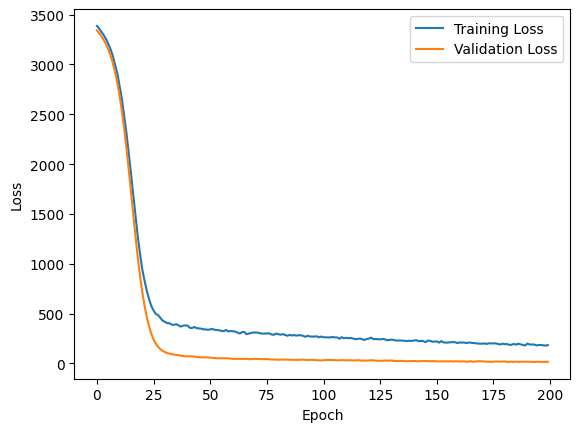

In [ ]:
# Se estadarizan las columnas.
# Se modela una red neuronal con 5 capas de entrada y una salida lineal.
# Se optimiza r2

scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1)
X_test_scaled1 = scaler.transform(X_test1)


model = tf.keras.Sequential([
          tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train_scaled1.shape[1],)),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(5, activation='leaky_relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(3, activation='leaky_relu'),
          tf.keras.layers.Dense(1, activation='linear')
        ])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

history = model.fit(X_train_scaled1, y_train1, epochs=200, batch_size=400, validation_split=0.2)

loss, mae = model.evaluate(X_test_scaled1, y_test1)

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred1 = model.predict(X_test_scaled1)
metricas(y_test1, y_pred1)

63/63 [==============================] - 0s 1ms/step
R2: 0.96
MSE: 16
RMSE: 4
MAE: 3
MAPE: 0.07


- Se evaluó el modelo utilizando métricas de regresión, incluyendo R cuadrado (R2), Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE), Error Absoluto Medio (MAE) y Error Porcentual Absoluto Medio (MAPE).
- Se graficó la pérdida durante el entrenamiento para visualizar la convergencia del modelo. (se podría haber colocado un valor menos a 200 epochs)
- La evaluación del modelo en el conjunto de prueba mostró un rendimiento satisfactorio con un R2 de 0.96, MSE de 16, RMSE de 4, MAE de 3 y MAPE de 0.07.

### Conclusiones:

- El modelo de regresión utilizando redes neuronales logró predecir con precisión el rendimiento académico de los estudiantes basado en las características proporcionadas.
- La alta correlación entre las puntuaciones previas y el índice de rendimiento sugiere que las puntuaciones previas son un predictor significativo del rendimiento académico futuro.
- La regularización L2 ayudó a evitar el sobreajuste del modelo.
- El rendimiento del modelo, con un R2 de 0.96 en el conjunto de prueba, indica una buena capacidad de generalización y predicción.


# Ejercicio 2

###Descripción:
En el siguiente problema, se presenta un conjunto de datos sobre diferentes variedades de frijoles secos. El objetivo es desarrollar un modelo de clasificación que pueda distinguir entre siete variedades registradas de frijoles secos, utilizando características como forma, tamaño, tipo y estructura. Se utilizó un sistema de visión por computadora para obtener imágenes de los granos de frijol y luego se llevó a cabo la segmentación y extracción de características para obtener un total de 16 atributos, incluidas 12 dimensiones y 4 formas.
###Dataset:
El dataset proporcionado incluye las siguientes variables para cada paciente:
- Area (A): El área de una zona de frijol y el número de píxeles dentro de sus límites.
- Perimeter (P): La circunferencia del frijol se define como la longitud de su borde.
- Major axis length (L): La distancia entre los extremos de la línea más larga que se puede dibujar desde un frijol.
- Minor axis length (l): La línea más larga que se puede dibujar desde el frijol mientras está perpendicular al eje principal.
- Eccentricity (Ec): Excentricidad de la elipse que tiene los mismos momentos que la región.
- Convex area (C): Número de píxeles en el polígono convexo más pequeño que puede contener el área de una semilla de frijol.
- Equivalent diameter (Ed): El diámetro de un círculo que tiene el mismo área que el área de una semilla de frijol.
- Extent (Ex): La relación de los píxeles en el cuadro delimitador con respecto al área del frijol.
- Solidity (S): También conocida como convexidad. La relación de los píxeles en la envoltura convexa con respecto a los que se encuentran en los frijoles.
- Compactness (CO): Mide la redondez de un objeto: Ed/L.
- ShapeFactor1 (SF1).
- ShapeFactor2 (SF2).
- ShapeFactor3 (SF3).
- ShapeFactor4 (SF4).
- Class: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz y Sira.

###Objetivo:
Utilizando el conjunto de datos proporcionado, el objetivo es construir un modelo de clasificación que pueda predecir con precisión la variedad de frijol seco basándose en las características mencionadas anteriormente. Se emplearán técnicas de aprendizaje automático, específicamente redes neuronales, para entrenar y evaluar el modelo.
Además, se requiere que el alumno calcule y agregue al conjunto de datos las siguientes características:
- Aspect ratio (K): Relación entre la longitud del eje mayor (L) y la longitud del eje menor (l) .
- Roundness (R): Se debe calcular utilizando la fórmula (4piA)/(P^2).
Estas nuevas características calculadas se utilizarán como parte del conjunto de datos para el entrenamiento y evaluación del modelo de clasificación.


##Resolución

In [ ]:
df = pd.read_csv("datasets/ej2/TP1-2-Dry-Bean-Dataset.csv", sep=',',engine='python')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   Eccentricity     13611 non-null  float64
 5   ConvexArea       13611 non-null  int64  
 6   EquivDiameter    13611 non-null  float64
 7   Extent           13611 non-null  float64
 8   Solidity         13611 non-null  float64
 9   Compactness      13611 non-null  float64
 10  ShapeFactor1     13611 non-null  float64
 11  ShapeFactor2     13611 non-null  float64
 12  ShapeFactor3     13611 non-null  float64
 13  ShapeFactor4     13611 non-null  float64
 14  Class            13611 non-null  object 
dtypes: float64(12), int64(2), object(1)
memory usage: 1.6+ MB


- Luegode cargar el dataset se crearon dos nuevas características: 'aspect_ratio' y 'roundness', como se indica en el objetivo del ejercicio.
- 'aspect_ratio' se calculó como la relación entre la longitud del eje mayor y la longitud del eje menor.
- 'roundness' se calculó utilizando la fórmula dada.
- Se realizó una gráfica de correlación lineal entre las características para entender su relación.

In [ ]:
# Agregamos columna aspect_ratio
def aspect_ratio(row):
  return row['MajorAxisLength'] / row['MinorAxisLength']

df['aspect_ratio'] = df.apply(aspect_ratio, axis=1)

In [ ]:
# Agregamos columna roundness

import math
def roundness(row):
  return 4 * math.pi * row['Area'] / (row['Perimeter']**2)

df['roundness'] = df.apply(roundness, axis=1)

In [ ]:
# Separamos en caracteristicas y variable objetivo

X = df.drop('Class', axis=1)
y = df['Class']

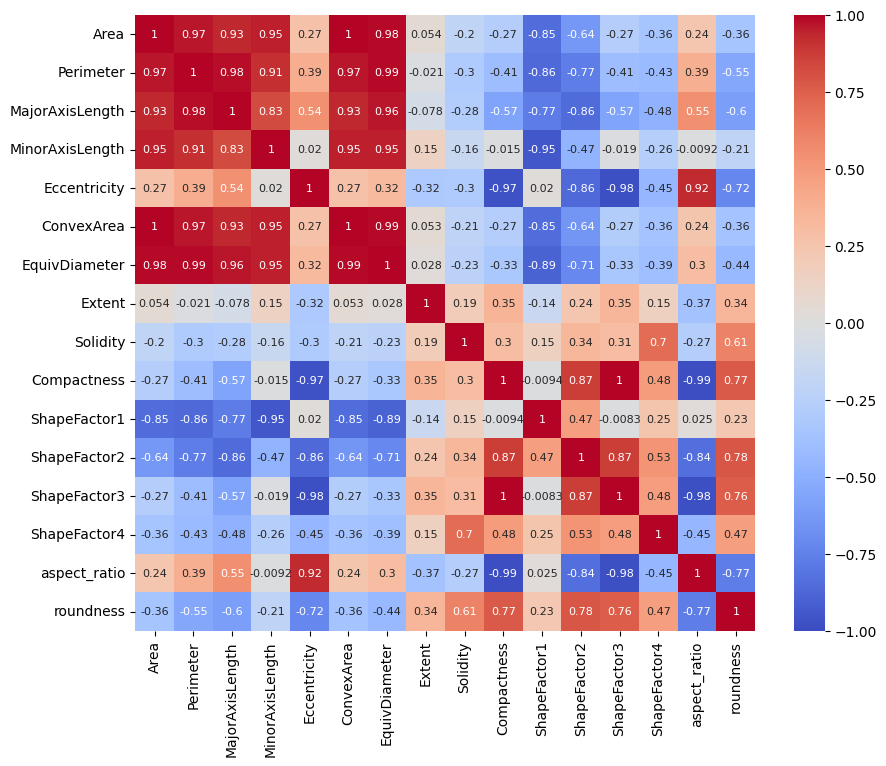

In [ ]:
# Grafica de correlacion lineal de las distintas features.

df_corr = X.corr()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    df_corr,
    vmin=-1, vmax=1, center=0,
    cmap="coolwarm",
    annot = True,
    annot_kws={"size": 8},
)
plt.show()

- Se realizó una codificación de etiquetas para convertir la variable objetivo de texto a numérica.
- Los datos se dividieron en conjuntos de entrenamiento y prueba (80/20) y se estandarizaron para una mejor convergencia.
- Se definió un modelo de red neuronal secuencial con dos capas ocultas, activación ReLU y una capa de salida con activación softmax.

In [ ]:
# Modificamos la variable objetivo para q no sea de tipo string
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
#Split y normalizacion de datos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Definir el modelo de red neuronal

model = tf.keras.Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))


#Entrenar y evaluar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/150
341/341 [==============================] - 3s 5ms/step - loss: 0.5354 - accuracy: 0.8266 - val_loss: 0.2449 - val_accuracy: 0.9122
Epoch 2/150
341/341 [==============================] - 1s 3ms/step - loss: 0.2316 - accuracy: 0.9181 - val_loss: 0.2153 - val_accuracy: 0.9225
Epoch 3/150
341/341 [==============================] - 1s 2ms/step - loss: 0.2130 - accuracy: 0.9236 - val_loss: 0.2043 - val_accuracy: 0.9266
Epoch 4/150
341/341 [==============================] - 1s 2ms/step - loss: 0.2032 - accuracy: 0.9265 - val_loss: 0.2018 - val_accuracy: 0.9243
Epoch 5/150
341/341 [==============================] - 1s 2ms/step - loss: 0.1978 - accuracy: 0.9267 - val_loss: 0.1998 - val_accuracy: 0.9273
Epoch 6/150
341/341 [==============================] - 1s 2ms/step - loss: 0.1941 - accuracy: 0.9273 - val_loss: 0.1975 - val_accuracy: 0.9277
Epoch 7/150
341/341 [==============================] - 1s 2ms/step - loss: 0.1931 - accuracy: 0.9293 - val_loss: 0.1963 - val_accuracy: 0.9299

- Se utilizóp para el modelo 'sparse_categorical_crossentropy' como función de pérdida y el optimizador 'adam'.
- Se entrenó el modelo durante 150 épocas con un tamaño de lote de 32, utilizando el conjunto de validación para ver el rendimiento.
- Después del entrenamiento, se evaluó el modelo en el conjunto de prueba, obteniendo una pérdida de 0.2097 y una precisión del 92.99%.

86/86 [==============================] - 0s 2ms/step


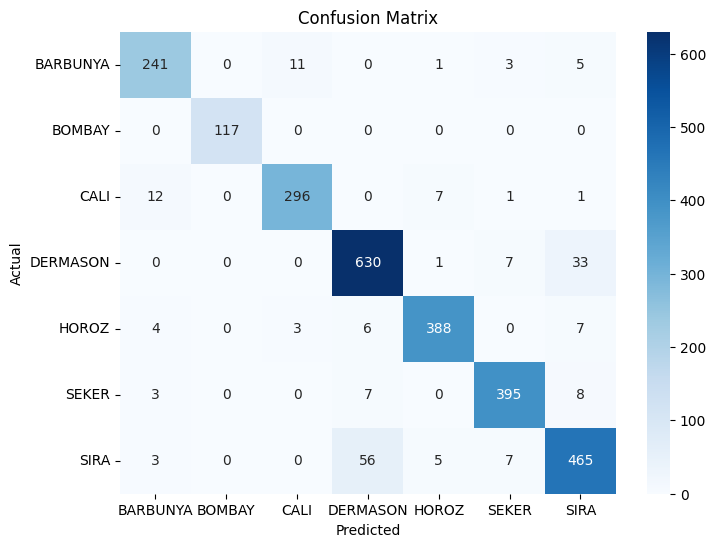

In [ ]:
# Creamos la matriz de confusión para visualizar los datos correctos y errores de las predicciones.

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Se creó una matriz de confusión para visualizar los resultados de las predicciones del modelo, mostrando las predicciones correctas y los errores de clasificación para cada clase de frijol.

###Conclusiones:

- El modelo de clasificación utilizando redes neuronales demostró un buen rendimiento en la tarea de distinguir entre las variedades de frijoles secos.
- La precisión del modelo fue del 92.99%, lo que indica una capacidad de generalización adecuada.
- Las nuevas características creadas ('aspect_ratio' y 'roundness') ayudaron a mejorar la capacidad predictiva del modelo.
- La matriz de confusión proporciona una comprensión visual de cómo el modelo clasifica correctamente e incorrectamente las diferentes variedades de frijoles secos.

# Ejercicio 3

###Descripción:
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.
###Dataset:
El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
- buildings
- forest
-glacier
-mountain
-sea
-street

Las imágenes están divididas en tres conjuntos:
- Train: Alrededor de 14,000 imágenes para entrenamiento.
- Test: Alrededor de 3,000 imágenes para evaluación del modelo.
- Prediction: Alrededor de 7,000 imágenes para predicción final.

###Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:
- Modelo con capas densas.
- Modelo con capas convolucionales y densas.
- Modelo que incluya bloques residuales identidad:
- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications

Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


##Resolución

- Se cargaron los datos de entrenamiento y validación utilizando el método image_dataset_from_directory de TensorFlow, dividiendo el conjunto de datos en entrenamiento y validación con una proporción del 80/20.

In [ ]:
# Directorio de los datos
DATA_DIRECTORY = Path("datasets/ej3")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
     f"{DATA_DIRECTORY}/train",
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
     f"{DATA_DIRECTORY}/test",
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [ ]:
# Clases del dataset

CLASS_NAMES = train_ds.class_names
num_classes = len(CLASS_NAMES)
print(CLASS_NAMES)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


**1) Modelo con capas densas**

- Se creó una función load_dataset para cargar las imágenes desde el directorio y normalizarlas.
- Las imágenes se redimensionaron a 64x64 píxeles y se convirtieron a escala de grises.
- Se mostraron algunos ejemplos de imágenes con sus respectivas etiquetas.

In [ ]:
def load_dataset(directory, target_size=(64, 64)):
    images = []
    labels = []
    classes = sorted(os.listdir(directory))
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path).convert('L')  # Convertir a grayscale
            image = image.resize(target_size)  # Resize the image
            image = np.array(image)
            images.append(image)
            labels.append(CLASS_NAMES[class_idx])
    return np.array(images), np.array(labels)

# Dataset folder
dataset_dir = 'datasets/ej3/'

# Cargar el dataset
X_train, y_train = load_dataset(os.path.join(dataset_dir, 'train'))
X_test, y_test = load_dataset(os.path.join(dataset_dir, 'test'))

# Normalizing the data
X_train, X_test = X_train / 255.0, X_test / 255.0
print("Ejemplos de entrenamiento:", X_train.shape)
print("Ejemplos de test:", X_test.shape)

Ejemplos de entrenamiento: (14034, 64, 64)
Ejemplos de test: (3000, 64, 64)


In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

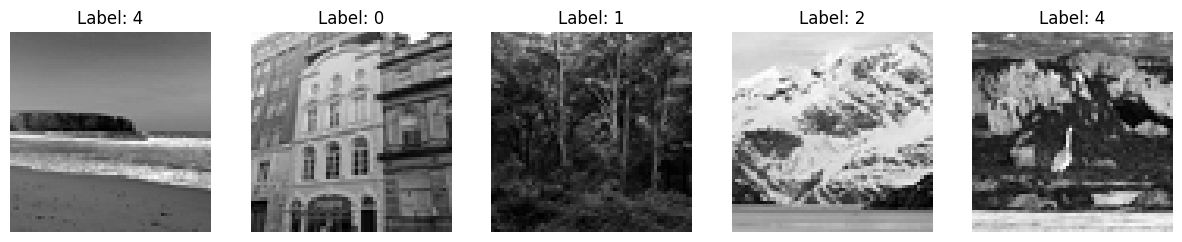

In [ ]:
# Mostramos algunos ejemplos al azar:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, X_train.shape[0])
    axs[i].imshow(X_train[idx], cmap='gray')
    axs[i].set_title(f"Label: {y_train[idx]}")
    axs[i].axis('off')
plt.show()

- Se construyó un modelo de red neuronal secuencial con tres capas densas.
- Se utilizó una capa Flatten para convertir las imágenes en un vector unidimensional.
- Se agregaron dos capas densas con activación ReLU y una capa de salida con activación softmax.

In [ ]:
model = tf.keras.Sequential([
        Flatten(input_shape=(64, 64)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer="adam",
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
439/439 [==============================] - 8s 14ms/step - loss: 2.1749 - accuracy: 0.1866 - val_loss: 2.0902 - val_accuracy: 0.1667
Epoch 2/100
439/439 [==============================] - 5s 11ms/step - loss: 2.0299 - accuracy: 0.1683 - val_loss: 1.9799 - val_accuracy: 0.1670
Epoch 3/100
439/439 [==============================] - 4s 8ms/step - loss: 1.9476 - accuracy: 0.1779 - val_loss: 1.9195 - val_accuracy: 0.1750
Epoch 4/100
439/439 [==============================] - 4s 9ms/step - loss: 1.9008 - accuracy: 0.1790 - val_loss: 1.8835 - val_accuracy: 0.1750
Epoch 5/100
439/439 [==============================] - 4s 10ms/step - loss: 1.8718 - accuracy: 0.1790 - val_loss: 1.8602 - val_accuracy: 0.1750
Epoch 6/100
439/439 [==============================] - 4s 8ms/step - loss: 1.8525 - accuracy: 0.1790 - val_loss: 1.8442 - val_accuracy: 0.1750
Epoch 7/100
439/439 [==============================] - 4s 8ms/step - loss: 1.8390 - accuracy: 0.1790 - val_loss: 1.8329 - val_accuracy: 0.1

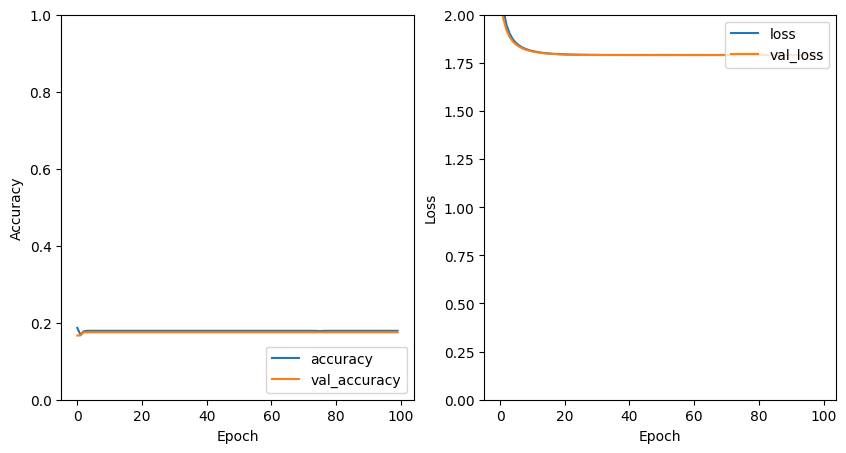

In [ ]:
# Como es esperable observamos malas metricas en el modelo con capas densas.
# Ademas se observa que es innecesario correr muchas epocas, ya que se estanca la mejora.
# Se podria implementar un EarlyStopping

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

###Conclusiones:

- El modelo de clasificación con capas densas mostró un rendimiento pobre en la tarea de clasificar imágenes de escenas naturales.
- Es evidente que un modelo simple de capas densas no es suficiente para capturar las características complejas de las imágenes.
- Se espera que mejoren los ersultados con modelos más avanzados, como las redes neuronales convolucionales (CNN) que veremos a continuación, que son más adecuadas para el procesamiento de imágenes.

**2) Modelo con redes convolucionales**

- Se definió una función build_model para construir el modelo de CNN.
- El modelo consta de varias capas convolucionales y de agrupación (pooling), seguidas de capas de aplanamiento Flatten y densas.
- Se utilizó la función de activación ReLU en las capas convolucionales.
- Se aplicaron técnicas de regularización, como la eliminación de dropout, para evitar el sobreajuste.

In [ ]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation (Random  (None, 64, 64, 3)         0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 64, 64, 3)         0         
 trast)                                                      

In [ ]:
# Entrena el modelo con checkpoint callback

checkpoint_acc = ModelCheckpoint(
    "convolutional-e{epoch:02d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc]
)

Epoch 1/30
176/176 [==============================] - 64s 342ms/step - loss: 1.3330 - accuracy: 0.4569 - val_loss: 1.0264 - val_accuracy: 0.5717
Epoch 2/30
176/176 [==============================] - 60s 335ms/step - loss: 1.0614 - accuracy: 0.5825 - val_loss: 0.9867 - val_accuracy: 0.6150
Epoch 3/30
176/176 [==============================] - 62s 353ms/step - loss: 0.9781 - accuracy: 0.6148 - val_loss: 0.8614 - val_accuracy: 0.6600
Epoch 4/30
176/176 [==============================] - 59s 334ms/step - loss: 0.9242 - accuracy: 0.6483 - val_loss: 0.8616 - val_accuracy: 0.6800
Epoch 5/30
176/176 [==============================] - 61s 346ms/step - loss: 0.8886 - accuracy: 0.6663 - val_loss: 0.8572 - val_accuracy: 0.6667
Epoch 6/30
176/176 [==============================] - 76s 431ms/step - loss: 0.8487 - accuracy: 0.6790 - val_loss: 0.7737 - val_accuracy: 0.7200
Epoch 7/30
176/176 [==============================] - 59s 336ms/step - loss: 0.8209 - accuracy: 0.6960 - val_loss: 0.8037 - val_ac

- Para el modelo se utilizó el optimizador 'adam' y la función de pérdida 'categorical_crossentropy'.
- Se entrenó el modelo durante 30 épocas utilizando el conjunto de entrenamiento y se evaluó su rendimiento en el conjunto de validación.
- Después del entrenamiento, se observó una precisión de aproximadamente 78.24% en el conjunto de entrenamiento y 78.67% en el conjunto de validación.

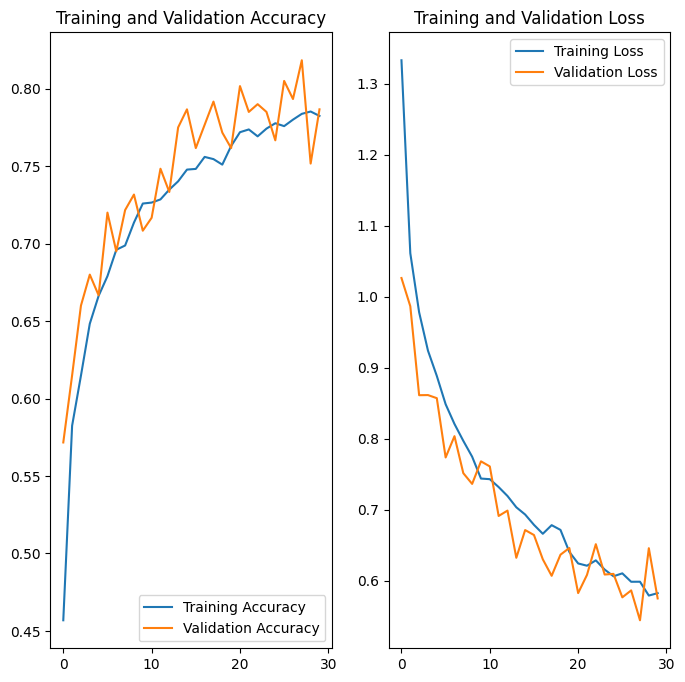

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Se graficaron las curvas de precisión y pérdida durante el entrenamiento y la validación para visualizar el rendimiento del modelo a lo largo del tiempo.
- Se observó una tendencia de mejora tanto en la precisión como en la pérdida en el conjunto de validación, lo que indica que el modelo está aprendiendo de manera efectiva las características de las imágenes.

1/1 [==============================] - 0s 158ms/step


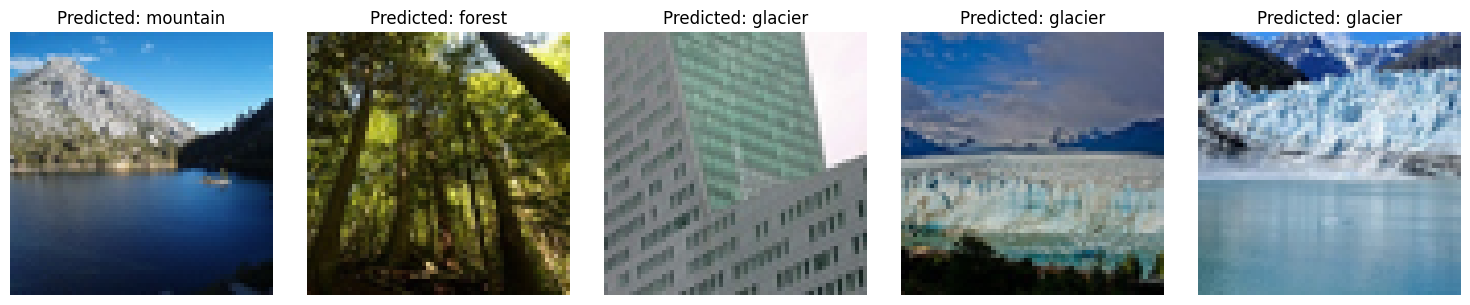

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("datasets/ej3/pred")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocess the image
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Perform prediction
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = CLASS_NAMES[predicted_class_index]

    # Display result
    ax.set_title(f"Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

- Se utilizó el modelo entrenado para hacer predicciones sobre nuevas imágenes no vistas antes.
- Se mostraron cinco imágenes de prueba junto con sus clases predichas, demostrando la capacidad del modelo para clasificar con precisión diferentes escenas naturales.

###Conclusiones:

- El modelo de clasificación utilizando redes neuronales convolucionales (CNN) demostró un rendimiento bastante bueno en la tarea de clasificar imágenes de escenas naturales en seis categorías predefinidas.
- A diferecnia del desempeño con las capas densas, las CNN mostraron que son una opción efectiva para tareas de clasificación de imágenes debido a su capacidad para aprender automáticamente característica

**3) Modelo con bloques residuales**

- Se definió una función build_model para construir el modelo de CNN con bloques residuales.
- El modelo consta de varios bloques residuales, cada uno con dos capas de convolución seguidas de la operación de salto.
- Se aplicaron técnicas de aumento de datos, como voltear, traslación aleatoria y contraste aleatorio, para mejorar la capacidad de generalización del modelo.

In [ ]:
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Primer bloque residual
    residual = Conv2D(8, (1, 1), padding='same')(x)  # Ajuste de dimensiones de residual
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Activation("relu")(x)
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Add()([residual, x])  # Conexión de salto
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    # Segundo bloque residual
    residual = Conv2D(16, (1, 1), padding='same')(x)  # Ajuste de dimensiones de residual
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Activation("relu")(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Add()([residual, x])  # Conexión de salto
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    # Tercer bloque residual
    residual = Conv2D(32, (1, 1), padding='same')(x)  # Ajuste de dimensiones de residual
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation("relu")(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Add()([residual, x])  # Conexión de salto
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    # Cuarto bloque residual
    residual = Conv2D(64, (1, 1), padding='same')(x)  # Ajuste de dimensiones de residual
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Add()([residual, x])  # Conexión de salto
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])


In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
Input shape: (64, 64, 3)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling_12 (Rescaling)    (None, 64, 64, 3)            0         ['input_13[0][0]']            
                                                                                                  
 random_flip_24 (RandomFlip  (None, 64, 64, 3)            0         ['rescaling_12[0][0]']        
 )                                                                                                
                                                                                                  
 random_flip_25 (RandomFlip  (None, 64, 64, 3)            0         ['random_flip_24[0][0]']

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
176/176 [==============================] - 77s 418ms/step - loss: 1.3382 - accuracy: 0.4275 - val_loss: 1.0764 - val_accuracy: 0.5550
Epoch 2/30
176/176 [==============================] - 74s 416ms/step - loss: 1.0840 - accuracy: 0.5516 - val_loss: 1.0605 - val_accuracy: 0.5633
Epoch 3/30
176/176 [==============================] - 70s 399ms/step - loss: 0.9804 - accuracy: 0.6079 - val_loss: 0.8678 - val_accuracy: 0.6667
Epoch 4/30
176/176 [==============================] - 73s 410ms/step - loss: 0.8959 - accuracy: 0.6529 - val_loss: 0.9131 - val_accuracy: 0.6400
Epoch 5/30
176/176 [==============================] - 72s 406ms/step - loss: 0.8477 - accuracy: 0.6780 - val_loss: 0.6965 - val_accuracy: 0.7467
Epoch 6/30
176/176 [==============================] - 72s 407ms/step - loss: 0.8078 - accuracy: 0.6959 - val_loss: 0.6341 - val_accuracy: 0.7817
Epoch 7/30
176/176 [==============================] - 72s 406ms/step - loss: 0.7706 - accuracy: 0.7104 - val_loss: 0.6885 - val_ac

- Para el modelo se utilizó el optimizador 'adam' y la función de pérdida 'categorical_crossentropy', con métricas de precisión.
- Se entrenó el modelo durante 30 épocas utilizando el conjunto de entrenamiento y se evaluó su rendimiento en el conjunto de validación.
- Después del entrenamiento, se observó una precisión de aproximadamente 81.83% en el conjunto de entrenamiento y 79.33% en el conjunto de validación.

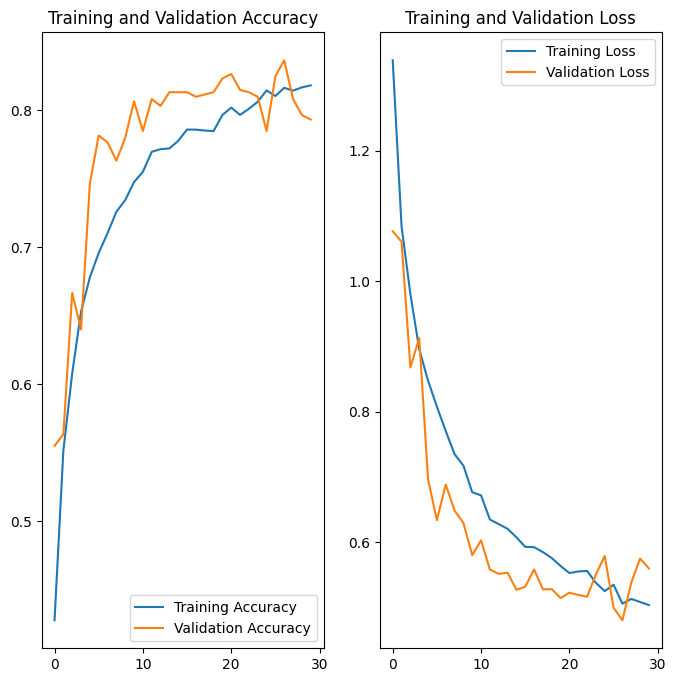

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Nuevamente se graficaron las curvas de precisión y pérdida durante el entrenamiento y la validación para visualizar el rendimiento del modelo a lo largo del tiempo.
- Se observó una tendencia de mejora tanto en la precisión como en la pérdida en el conjunto de validación, lo que indica que el modelo está aprendiendo de manera efectiva las características de las imágenes.

1/1 [==============================] - 0s 23ms/step


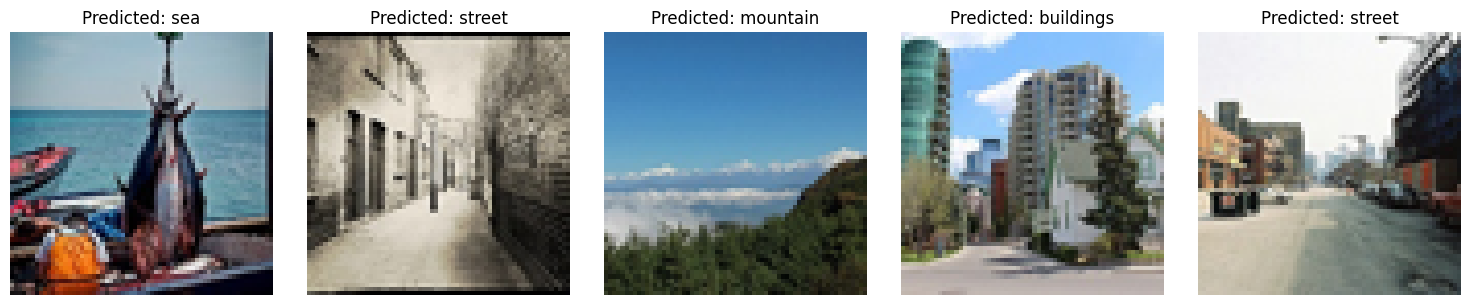

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("datasets/ej3/pred")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocess the image
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Perform prediction
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = CLASS_NAMES[predicted_class_index]

    # Display result
    ax.set_title(f"Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

- En esta parte se utilizó el modelo entrenado para hacer predicciones sobre nuevas imágenes.
- Se mostraron cinco imágenes de prueba junto con sus clases predichas, demostrando la capacidad del modelo para clasificar con precisión diferentes escenas naturales.

###Conclusiones:

- El modelo de clasificación utilizando bloques residuales en una red neuronal convolucional (CNN) obtuvo una presición bastante buena  en la tarea de clasificar las imágenes de escenas naturales de las seis categorís.
- Este modelo con los bloques residuales obtuvo un rendimiento un poco mejor que el modelo anterior CNN.

** 4) Transfer learning **


In [ ]:
# Se define arquiectura con transfer learning utilizando Efficientnet

def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])



Building model


In [ ]:
model.summary()

In [ ]:
# Entrena el modelo

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=BATCH_SIZE
)

Epoch 1/30
176/176 [==============================] - 14s 38ms/step - loss: 0.7439 - accuracy: 0.7465 - val_loss: 0.4852 - val_accuracy: 0.8467
Epoch 2/30
176/176 [==============================] - 5s 30ms/step - loss: 0.5291 - accuracy: 0.8317 - val_loss: 0.4467 - val_accuracy: 0.8550
Epoch 3/30
176/176 [==============================] - 6s 36ms/step - loss: 0.4626 - accuracy: 0.8569 - val_loss: 0.4388 - val_accuracy: 0.8567
Epoch 4/30
176/176 [==============================] - 6s 31ms/step - loss: 0.4313 - accuracy: 0.8658 - val_loss: 0.4417 - val_accuracy: 0.8600
Epoch 5/30
176/176 [==============================] - 5s 30ms/step - loss: 0.4077 - accuracy: 0.8760 - val_loss: 0.4581 - val_accuracy: 0.8633
Epoch 6/30
176/176 [==============================] - 7s 36ms/step - loss: 0.3837 - accuracy: 0.8823 - val_loss: 0.4545 - val_accuracy: 0.8717
Epoch 7/30
176/176 [==============================] - 5s 30ms/step - loss: 0.3690 - accuracy: 0.8886 - val_loss: 0.4813 - val_accuracy: 0.865

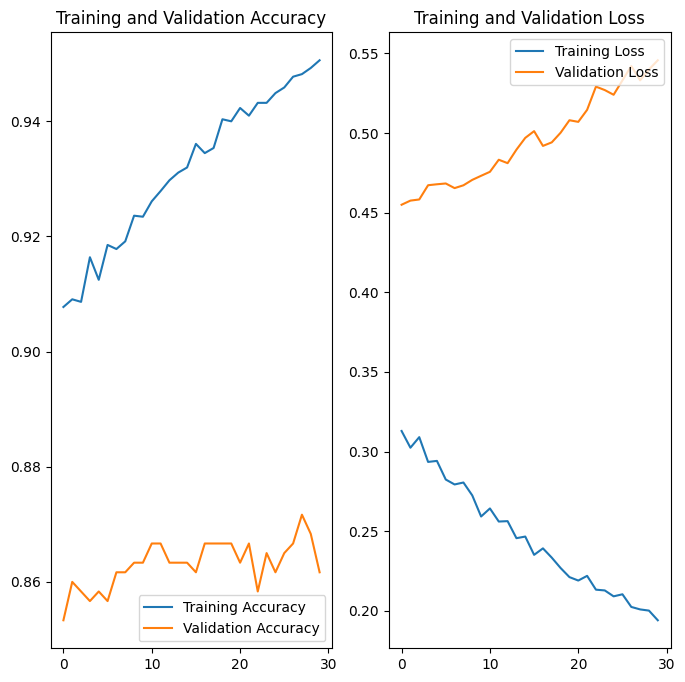

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*******************VER********************

- Se utilizó la arquitectura EfficientNetB0 como modelo base preentrenado.
- Se congelaron los pesos del modelo base para evitar que se actualicen durante el entrenamiento.
- Se agregaron capas adicionales en la parte superior del modelo base para adaptarlo a la tarea de clasificación de imágenes.
- Se utilizaron capas de agrupamiento global máximo, capas densas con activación ReLU y capas de dropout para regularizar el modelo y evitar el sobreajuste.
- La capa de salida consistió en una capa densa con activación softmax para generar las predicciones de clase.

In [ ]:
import tensorflow as tf
#from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    # Agrega unas pocas capas más a la parte superior del modelo base
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.5)(x)

    # Capa de salida
    predictions = Dense(num_classes, activation='softmax')(x)

    # Define el modelo
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    return model

# Crea el modelo
model = build_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=num_classes)

# Compila el modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    verbose=1)



Epoch 1/30
176/176 [==============================] - 81s 410ms/step - loss: 1.4149 - accuracy: 0.4800 - val_loss: 0.7147 - val_accuracy: 0.7783
Epoch 2/30
176/176 [==============================] - 71s 404ms/step - loss: 0.8489 - accuracy: 0.7062 - val_loss: 0.5738 - val_accuracy: 0.8083
Epoch 3/30
176/176 [==============================] - 75s 427ms/step - loss: 0.7226 - accuracy: 0.7526 - val_loss: 0.5357 - val_accuracy: 0.8283
Epoch 4/30
176/176 [==============================] - 93s 527ms/step - loss: 0.6453 - accuracy: 0.7863 - val_loss: 0.5124 - val_accuracy: 0.8333
Epoch 5/30
176/176 [==============================] - 79s 448ms/step - loss: 0.6064 - accuracy: 0.8023 - val_loss: 0.5000 - val_accuracy: 0.8383
Epoch 6/30
176/176 [==============================] - 78s 440ms/step - loss: 0.5761 - accuracy: 0.8144 - val_loss: 0.4939 - val_accuracy: 0.8333
Epoch 7/30
176/176 [==============================] - 77s 434ms/step - loss: 0.5576 - accuracy: 0.8196 - val_loss: 0.4840 - val_ac

- El modelo se compiló utilizando el optimizador Adam con una tasa de aprendizaje de 0.0001 y la función de pérdida de entropía cruzada categórica.
- Se entrenó el modelo durante 30 épocas utilizando el conjunto de entrenamiento y se evaluó su rendimiento en el conjunto de validación.
- Después del entrenamiento, se observó una precisión de aproximadamente 90.83% en el conjunto de entrenamiento y 86.50% en el conjunto de validación.
- Los resultados muestran un rendimiento muy bueno del modelo en la tarea de clasificación de imágenes, con una precisión significativamente mejor que los modelos anteriores.

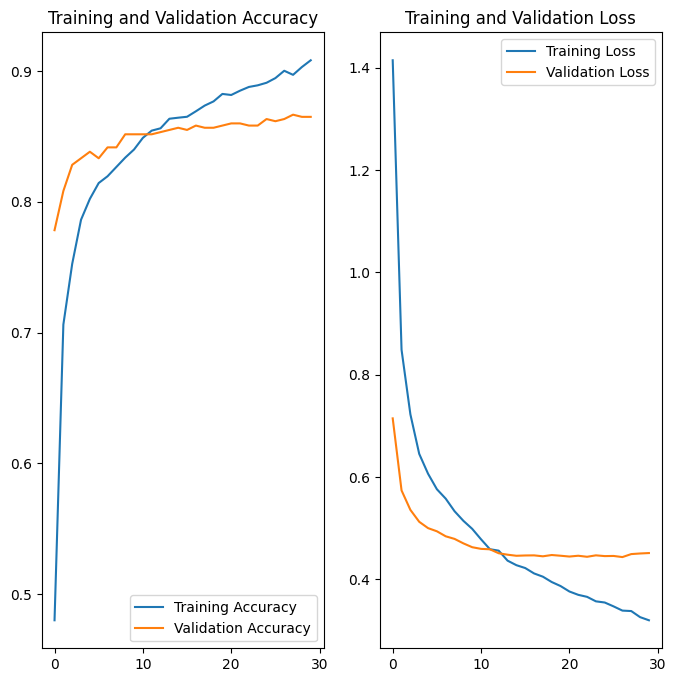

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Se graficaron las curvas de precisión y pérdida durante el entrenamiento y la validación para visualizar el rendimiento del modelo a lo largo del tiempo.
- Se observa que el modelo no muestra signos de sobreajuste, ya que las curvas de precisión y pérdida en el conjunto de validación siguen la tendencia de las curvas en el conjunto de entrenamiento.

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("datasets/ej3/pred")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocess the image
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Perform prediction
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = CLASS_NAMES[predicted_class_index]

    # Display result
    ax.set_title(f"Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

###Conclusiones:

- El modelo de clasificación utilizando transfer learning con EfficientNetB0 preentrenado demostró un rendimiento excepcional en la tarea de clasificación de imágenes de escenas naturales.
- Con Transfer learning se aprovechpo el conocimiento aprendido por modelos previamente entrenados en conjuntos de datos masivos y  mejorar significativamente el rendimiento en este conjunto de datos más pequeños.